# CMPE 255 Project

## Predict release timeframe of songs from audio features

#### Team members:
##### Ashutosh Patil, Ganesh Susarla, Sagar Sutar, Sayali Nilangekar

#### Summary
We will run different classifier models on our YearPredictionMSD dataset. This will be a multi class classification, where the classes are decades based on the years in the dataset. We will then find which classifier model is most accurate, try to improve it, and then make predictions on the validation dataset using that as the final model.

In [4]:
# Imports

import numpy as np
import pandas as pd
import os
import shutil
import urllib.request
import zipfile
import requests
import matplotlib.pyplot as plt
import seaborn as sb
import time

from datetime import datetime
from pandas import read_csv

from sklearn.preprocessing import MinMaxScaler

from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from joblib import dump
from joblib import load

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier


# Const seed value 
seedNum = 255

### Load the dataset

For this project we are using the YearPredictionMSD, from the UCI ML repository: https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd


In [6]:
dataFrame = pd.read_csv('YearPredictionMSD.txt', sep=',', header=None)

### Plot data 

Text(0.5, 1.0, 'Distribution of audio samples by year and count')

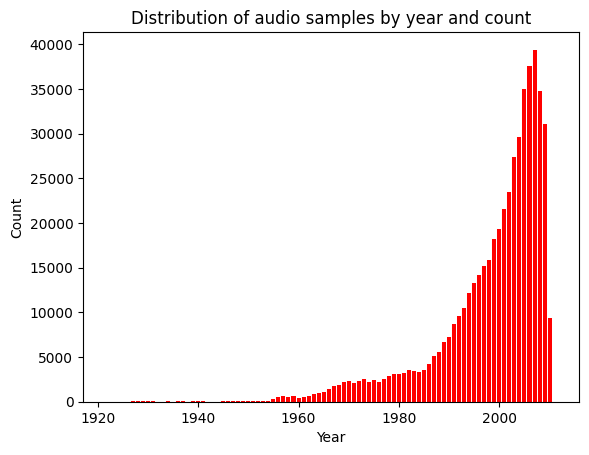

In [7]:
X = dataFrame.iloc[:,1:]
Y = dataFrame.iloc[:,0]

years = Y.unique()
num_samples_per_year = dict(Y.value_counts())
counts_ordered = [num_samples_per_year[year] for year in years]
plt.bar(years, counts_ordered, color='red')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Distribution of audio samples by year and count')

As we can see, the distribution of audio samples is concentrated more for the years 1980 and later. We will create classes based on decades so that we can club 10 years together and identify which decade a song belongs to.

Text(0.5, 1.0, 'Samples in the dataset/release decade')

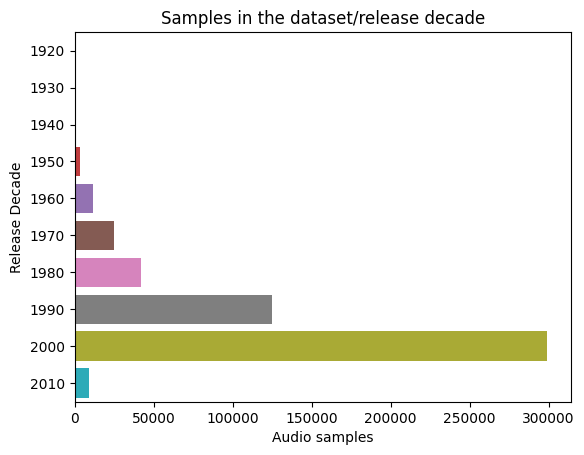

In [8]:
dataFrame['label'] = dataFrame[0].apply(lambda year : year-(year%10))

sb.countplot(y="label", data=dataFrame)

plt.xlabel("Audio samples")
plt.ylabel("Release Decade")
plt.title("Samples in the dataset/release decade")

As you can see above, the data is plotted decade-wise and we will be sorting the samples into decades similarly.

### Create classes based on decades

In [9]:
# Assign 1 to the first decade (1930 - 1939) and so on
dataFrame['classes'] = dataFrame.iloc[:,0].apply(lambda x: 
    1 if (x >= 1930 and x <= 1939) else 
    2 if (x >= 1940 and x <= 1949) else 
    3 if (x >= 1950 and x <= 1959) else 
    4 if (x >= 1960 and x <= 1969) else 
    5 if (x >= 1970 and x <= 1979) else 
    6 if (x >= 1980 and x <= 1989) else 
    7 if (x >= 1990 and x <= 1999) else 
    8 if (x >= 2000 and x <= 2009) else 
    9 if (x >= 2010 and x <= 2019) else 0)


### Create train and test data 

In [10]:
X = dataFrame.iloc[:,1:91]
Y = dataFrame['classes']

X_train = X.iloc[0:463715, :].to_numpy()
Y_train = Y.iloc[0:463715].to_numpy()

X_test = X.iloc[463715:, :].to_numpy()
Y_test = Y.iloc[463715:].to_numpy()

# Check dimensions of numpy arrays
print("X_train.shape: {} Y_train.shape: {}".format(X_train.shape, Y_train.shape))
print("X_test.shape: {} Y_test.shape: {}".format(X_test.shape, Y_test.shape))


X_train.shape: (463715, 90) Y_train.shape: (463715,)
X_test.shape: (51630, 90) Y_test.shape: (51630,)


In [11]:
pd.DataFrame(X_train).describe()

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
count,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,...,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000
mean,43.385488,1.261091,8.650195,1.130763,-6.512725,-9.565527,-2.384609,-1.793722,3.714584,1.872495,...,15.743361,-73.067753,41.423976,37.780868,0.345259,17.599280,-26.364826,4.444985,19.739307,1.323326
std,6.079139,51.613473,35.264750,16.334672,22.855820,12.836758,14.580245,7.961876,10.579241,6.522868,...,32.086356,175.376872,121.794610,94.874474,16.153797,114.336522,174.187892,13.320996,184.843503,22.045404
min,1.749000,-337.092500,-301.005060,-154.183580,-181.953370,-81.794290,-188.214000,-72.503850,-126.479040,-41.631660,...,-437.722030,-4402.376440,-1810.689190,-3098.350310,-341.789120,-3168.924570,-4319.992320,-236.039260,-7458.378150,-318.223330
25%,39.957540,-26.153810,-11.441920,-8.515155,-20.636960,-18.468705,-10.776340,-6.461400,-2.303600,-2.448450,...,-1.798085,-139.062035,-20.918635,-4.711470,-6.758160,-31.563615,-101.396245,-2.572830,-59.598030,-8.813335
50%,44.262570,8.371550,10.470520,-0.691610,-5.992740,-11.208850,-2.047850,-1.735440,3.816840,1.775310,...,9.161360,-52.878010,28.709870,33.494550,0.828350,15.554490,-21.123570,3.111120,7.586950,0.052840
75%,47.833650,36.143780,29.741165,8.756995,7.749590,-2.422590,6.515710,2.905130,9.950960,6.128885,...,26.248290,13.620660,89.419995,77.674700,8.495715,67.743725,52.299850,9.948955,86.203115,9.670740
max,61.970140,384.065730,322.851430,289.527430,262.068870,119.815590,172.402680,105.210280,146.297950,60.345350,...,840.973380,4469.454870,3210.701700,1672.647100,260.544900,3662.065650,2833.608950,463.419500,7393.398440,600.766240


In [12]:
pd.DataFrame(Y_train).describe()

,0
count,463715.000000
mean,7.336782
std,1.082469
min,0.000000
25%,7.000000
50%,8.000000
75%,8.000000
max,9.000000


### Preprocessing

In [11]:
scaler = MinMaxScaler()
scaler.fit(X_train) 
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [44]:
dump(scaler, 'minmaxscaler_classification.joblib')

['minmaxscaler_classification.joblib']

### Dimensionality reduction

In [12]:
pca_dr = PCA(n_components=0.85)
pca_dr.fit(X_train)
X_train = pca_dr.transform(X_train)
X_test = pca_dr.transform(X_test)

### Training different classifier models

In [13]:
# Initializations
num_folds = 10
scoring = 'accuracy'
cpu_num = 6
results, names, metrics = [],[],[]
trainTimes = []

# Create a dictionary to hold all algorithms we will use
models = {
          'LDA': LinearDiscriminantAnalysis(),
          'KNN': KNeighborsClassifier(n_jobs=cpu_num),
          'DT': DecisionTreeClassifier(random_state=seedNum),
          'RF': RandomForestClassifier(random_state=seedNum, n_jobs=cpu_num),
          'ET': ExtraTreesClassifier(random_state=seedNum, n_jobs=cpu_num),
          'BT': BaggingClassifier(random_state=seedNum, n_jobs=cpu_num),
}

# Train models from dictionary
for name, model in models.items():
    
    # Get start time to check how long model takes to train
    trainStart = datetime.now()
    trainStartSec = time.time()
    # We will run 10-fold cross validation, so create kfold with 10 splits
    kfold = KFold(n_splits = num_folds)
    
    # Find out cross validation score for model
    crossValScore = cross_val_score(model, X_train, Y_train, cv = kfold, scoring = scoring)
    
    results.append(crossValScore)
    names.append(name)
    metrics.append(crossValScore.mean())
    trainTimes.append((time.time() - trainStartSec))
    
    msg = "%s: %f (%f)" % (name, crossValScore.mean(), crossValScore.std())
    print(msg)
    print('Model training time:', (datetime.now() - trainStart))
    
print('Average accuracy (' + scoring + ') from all models:', np.mean(metrics))

LDA: 0.605126 (0.010518)
Model training time: 0:01:48.933665
KNN: 0.506654 (0.009370)
Model training time: 0:19:56.182614
DT: 0.484319 (0.005947)
Model training time: 0:19:01.665586
RF: 0.615738 (0.012325)
Model training time: 1:11:33.015069
ET: 0.602180 (0.014030)
Model training time: 0:28:41.359464
BT: 0.587115 (0.008977)
Model training time: 1:14:39.154908
Average accuracy (accuracy) from all models: 0.5668553696128393


In [31]:
dump(models, 'classfication-models/classificationModels.joblib')

['classfication-models/classificationModels.joblib']

In [17]:
models = load('classificationModels.joblib')

### Plot train times

Text(0, 0.5, 'Time in Seconds')

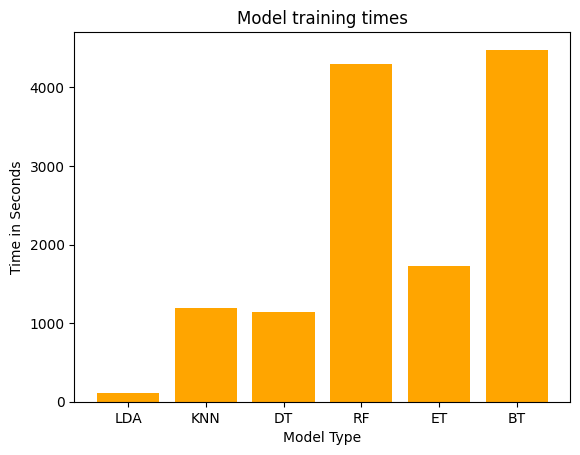

In [18]:
model_x_labels = [key for key in models.keys()]
trainTimes = [108.93,1196.18,1141.6,4293.02,1721.36,4479.16]
plt.bar(model_x_labels, trainTimes, color='orange') 
plt.title('Model training times')
plt.xlabel('Model Type')
plt.ylabel('Time in Seconds')

### Plot accuracies

Text(0, 0.5, 'Time in Seconds')

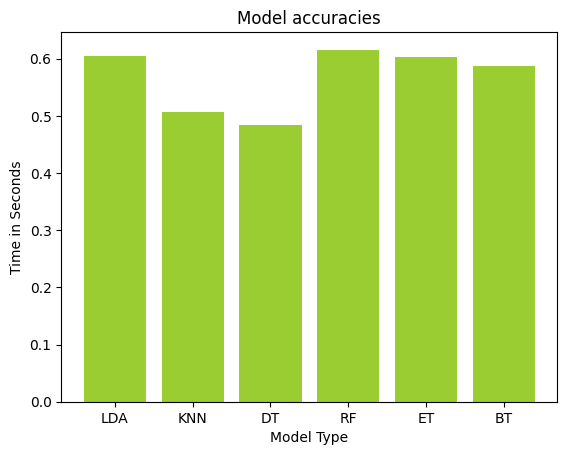

In [19]:
model_x_labels = [key for key in models.keys()]
scores = [0.605126,0.506654,0.484319,0.615738,0.602180,0.587115]
plt.bar(model_x_labels, scores, color='yellowgreen') 
plt.title('Model accuracies')
plt.xlabel('Model Type')
plt.ylabel('Time in Seconds')

After running all algorithms, we found that the Random Forest Classifier gave the most accuracy.

### Specify final model and make predictions




We have selected the Random Forest Classification model as our final classification model,
and now we will use it to make predictions.

In [24]:
# Use model to make predictions
model = RandomForestClassifier(random_state = seedNum, n_jobs = cpu_num, n_estimators = 500)
model.fit(X_train, Y_train)

predictions = model.predict(X_test)

# Print results
print("Accuracy score: ",accuracy_score(Y_test, predictions))
print("F1 score: ",f1_score(Y_test, predictions, average='micro'))
print(confusion_matrix(Y_test, predictions))
print(classification_report(Y_test, predictions))

Accuracy score:  0.6210923881464265
F1 score:  0.6210923881464265
[[    0     0     0     0     0     0     0    20     0     0]
 [    0     0     0     0     0     0     0    12     1     0]
 [    0     0     0     0     0     0     0    36    25     0]
 [    0     0     0     0     0     0     2   111   162     0]
 [    0     0     0     0     0    11    17   389   749     0]
 [    0     0     0     0     0    37    58   664  1637     0]
 [    0     0     0     0     0    10   483  1571  2137     0]
 [    0     0     0     1     0     9   173  3297  9100     0]
 [    0     0     0     0     0    19    50  1566 28250     0]
 [    0     0     0     0     0     1     2    27  1003     0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00        61
           3       0.00      0.00      0.00       275
           4       0.00      0.0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [25]:
trainStart = datetime.now()

print("X.shape: {} Y.shape: {}".format(X.shape, Y.shape))

finalModel = RandomForestClassifier(random_state = seedNum, n_jobs = cpu_num, n_estimators = 500)
finalModel.fit(X, Y)


print ('Model training time:',(datetime.now() - trainStart))

X.shape: (515345, 90) Y.shape: (515345,)
Model training time: 0:14:09.631597
